# ECE661 Final Project: Adversarial Patches

## Paul Truitt, Alok Malhotra

In this project, we will implement and experiment with the patch attack methods described in [Tom Brown et al's 2018 Research Paper](https://arxiv.org/pdf/1712.09665.pdf). We will run whitebox attacks on various CIFAR-10 models. We will see the way that it effects both model prediction accuracy as well as rate of successfully hitting the target class. We will measure these for various patch sizes. Then we will test blackbox transfer attacks. And finally, we will see its affectiveness on models adversarially trained against general PGD or FGSM attacks.

## Setup

In [1]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2023, 0.1994, 0.201])

In [61]:
train_dataset = CIFAR10(root='./data',
                                 train=True,
                                 transform=transforms.Compose([transforms.ToTensor(),normalize]),
                                 download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=4,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

Files already downloaded and verified


In [5]:
test_dataset = CIFAR10(root='./data',
                                 train=False,
                                 transform=transforms.Compose([transforms.ToTensor(),normalize]),
                                 download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

Files already downloaded and verified


In [6]:
NUM_CLASSES = 10

Loading pretrained CIFAR-10 models from [chenyaofo's cifar-10 pytorch repository](https://github.com/chenyaofo/pytorch-cifar-models).

In [7]:
import torch

resnet20 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
resnet56 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
vgg16 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
mobilenet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_4", pretrained=True)
shufflenet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_shufflenetv2_x2_0", pretrained=True)
repvgg = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_repvgg_a2", pretrained=True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt


  0%|          | 0.00/1.09M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt


  0%|          | 0.00/3.39M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg16_bn-6ee7ea24.pt


  0%|          | 0.00/58.3M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x1_4-3bbbd6e2.pt" to /root/.cache/torch/hub/checkpoints/cifar10_mobilenetv2_x1_4-3bbbd6e2.pt


  0%|          | 0.00/16.8M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar10_shufflenetv2_x2_0-ec31611c.pt" to /root/.cache/torch/hub/checkpoints/cifar10_shufflenetv2_x2_0-ec31611c.pt


  0%|          | 0.00/20.7M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar10_repvgg_a2-09488915.pt" to /root/.cache/torch/hub/checkpoints/cifar10_repvgg_a2-09488915.pt


  0%|          | 0.00/103M [00:00<?, ?B/s]

Testing the accuracy of pretrained models

In [8]:
def validate(model,loader):
    global device
    model.eval()
    correct = 0.
    total = 0.
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(images)

        pred = torch.max(pred.data, 1)[1]
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    val_acc = (correct / total)*100
    model.train()
    return val_acc

In [9]:
device = torch.device("cuda")

In [ ]:
print(validate(resnet20.to(device), test_loader))

92.60000000000001


In [ ]:
print(validate(resnet56.to(device), test_loader))

94.37


In [ ]:
print(validate(vgg16.to(device), test_loader))

94.16


In [ ]:
print(validate(mobilenet.to(device), test_loader))

94.21000000000001


In [ ]:
print(validate(shufflenet.to(device), test_loader))

93.97999999999999


In [ ]:
print(validate(repvgg.to(device), test_loader))

95.27


Pretrained Models Test Accuracies:

| Model      | Accuracy |
| ----------- | ----------- |
| Resnet20      | 89.2%       |
| Resnet56   | 94.37%        |
| VGG16      | 94.16%       |
| Mobilenet   | 94.21%        |
| Shufflenet      | 93.98%       |
| Repvgg   | 95.27%        |

## Work

In [10]:
MODELS = {
    'Resnet20': resnet20,
    'Resnet56': resnet56,
    'vgg': vgg16,
    'mobilenet': mobilenet,
    'shufflenet': shufflenet,
    'Repvgg': repvgg
}

In [11]:
# Compute the gradient of the loss w.r.t. the input data
# Taken from Homework 5 of Duke ECE661 by Dr. Yiran Chen
def gradient_wrt_data(model,device,data,lbl):
    dat = data.clone().detach()
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out,lbl)
    model.zero_grad()
    loss.backward()
    data_grad = dat.grad.data
    return data_grad.data.detach()

In [12]:
def get_first_non_zero(input):
  for i in range(len(input)):
    for j in range(len(input[i])):
      for k in range(len(input[i][j])):
        if input[i][j][k] != 0:
          return j, k
  return 0, 0

In [13]:
def collect_patch(full_patch, shape, device):
  np_full = full_patch.cpu().detach().numpy()
  patch = np.zeros(shape)

  y, x = get_first_non_zero(np_full)

  for i in range(shape[0]):
    for j in range(shape[1]):
      for k in range(shape[2]):
        full = np_full[i][y + j][x + k]
        patch[i][j][k] = full
  
  return torch.from_numpy(patch).to(device)

In [14]:
def attack_batch(model, target, data, patch, device, attack_targeted, labels, learning_rate=1, max_iters=1):
  # Perform the attack loop on an image
  model.eval()

  data_np = data.cpu().detach().numpy()
  batch_size = data_np.shape[0]

  full_patchs, masks = get_full_patch(data, patch, device)
  cutout_image = torch.mul(1-masks, data)
  adv_imgs = torch.add(cutout_image, full_patchs)

  conf = 0
  target_label = torch.from_numpy(np.ones(data_np.shape[0], dtype=np.int64) * target).to(device) if attack_targeted else target

  iterations = 0
  while iterations < max_iters:
    grad = learning_rate * gradient_wrt_data(model, device, adv_imgs.float(), target_label)

    new_patch = torch.sub(full_patchs, grad) if attack_targeted else torch.add(full_patchs, grad)
    new_patch[:][0] = torch.clamp(new_patch[:][0], min=-2.429, max=2.514).detach()
    new_patch[:][1] = torch.clamp(new_patch[:][1], min=-2.418, max=2.597).detach()
    new_patch[:][2] = torch.clamp(new_patch[:][2], min=-2.221, max=2.754).detach()
    full_patchs = torch.mul(new_patch, masks)

    adv_imgs = torch.add(cutout_image, full_patchs)
    iterations += 1

  avg_patch = torch.mean(full_patchs, 0)
  output = model(adv_imgs.float())
  _, preds = output.max(1)
  correct = preds.eq(labels).sum().item()

  patch = collect_patch(avg_patch, patch.shape, device)
  return patch, correct / batch_size


In [15]:
def get_full_patch(data, patch, device, fixed_location=None):
  patch_np = patch.cpu().detach().numpy()
  data_np = data.cpu().detach().numpy()

  if fixed_location is None:
    top = np.random.randint(0, data_np.shape[2] - patch_np.shape[1])
    right = np.random.randint(0, data_np.shape[3] - patch_np.shape[2])
  else:
    top = fixed_location[0]
    right = fixed_location[1]

  mask = np.zeros(data.shape)
  full_patch = np.zeros(data.shape)
  for n in range(data_np.shape[0]):
    for i in range(patch_np.shape[0]):
      for j in range(patch_np.shape[1]):
        for k in range(patch_np.shape[2]):
          full_patch[n][i][top + j][right + k] = patch_np[i][j][k]
          mask[n][i][top + j][right + k] = 1
  return torch.from_numpy(full_patch).to(device), torch.from_numpy(mask).to(device)

In [88]:
def train_patch(model, data_loader, target, device, patch_size=(3,3), max_iters=30, conf_level=1):
  # Loops through all of the data and updates the patch according to it
  model.eval()

  patch = torch.from_numpy(np.zeros((3, patch_size[0], patch_size[1]))).to(device)

  for i in range(10):
    batch_num = 0
    ep_acc = 0
    lr = 1
    for batch_idx, (data, labels) in enumerate(data_loader):
      data = data.to(device) 
      labels = labels.to(device)

      # print(str(target))
      # print(str(type(labels.cpu().data[0].numpy())))

      # Skip images where the true label is the target label, assuming we
      # are performing a targeted attack. For untargeted, no reason to skip.
      if target == labels.cpu().data[0].numpy() and target != None: continue
      
      batch_num += 1

      # If target == None, this attack is untargeted, so we use the true label as our target label.
      # Otherwise, we use the intended target label
      target = labels.cpu().data[0].numpy() if target == None else target
      attack_targeted = False if target == None else True

      patch, acc = attack_batch(model, target, data, patch, device, attack_targeted, labels, learning_rate=lr)
      ep_acc += acc
      batch_num += 1

      if batch_num >= 10000: break

    print('Epoch Accuracy: ', ep_acc / batch_num)
  return patch

In [32]:
def test_patch(model, data_loader, target, patch, device):
  model.eval()
  patch_success = 0
  model_success = 0
  total = 0

  for batch_idx, (data, labels) in enumerate(data_loader):
    # Skip images where the true label is the target label, assuming we
    # are performing a targeted attack. For untargeted, no reason to skip.
    if target == labels.data[0] and target != None: continue
    
    total += 1
    data = data.to(device) 
    labels = labels.to(device)\
    
    full_patch, mask = get_full_patch(data, patch, device)
    cutout_image = torch.mul(1-mask, data)
    adv_img = torch.add(cutout_image, full_patch)

    adv_label = model(adv_img.float()).data.max(1)[1][0]
    orig_label = labels.data[0]

    if target != None and adv_label == target: patch_success += 1
    elif adv_label == orig_label: model_success += 1
  
  print('Model test accuracy: ' + f'{model_success / total:.2f}')
  print('Patch test accuracy: ' + f'{patch_success / total:.2f}')
  

In [18]:
def imshow(img):
  timg = torch.clone(img)
  timg[0] = img[0] * 0.2023 + 0.4914
  timg[1] = img[1] * 0.1994 + 0.4822
  timg[2] = img[2] * 0.201 + 0.4465
  npimg = timg.numpy()   # convert from tensor
  print(npimg.min())
  print(npimg.max())
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Untargeted Attacks on ResNet-20

In [30]:
my_patch_resnet20_3x3_untargeted = train_patch(MODELS['Resnet20'].to(device), train_loader, None, device, (3,3))

Epoch Accuracy:  0.47374776386404294
Epoch Accuracy:  0.4679894416607015
Epoch Accuracy:  0.46673675733715103
Epoch Accuracy:  0.4660880458124553
Epoch Accuracy:  0.46637884753042236
Epoch Accuracy:  0.46517090193271293
Epoch Accuracy:  0.4636721546170365
Epoch Accuracy:  0.46596501431639226
Epoch Accuracy:  0.46592027559055116
Epoch Accuracy:  0.46490246957766646


In [31]:
d_resnet20_3x3_untargeted = test_patch(MODELS['Resnet20'], test_loader, None, my_patch_resnet20_3x3_untargeted, device)

Model test accuracy: 0.86
Patch test accuracy: 0.00


-0.006475897238783335
1.0156045935480664


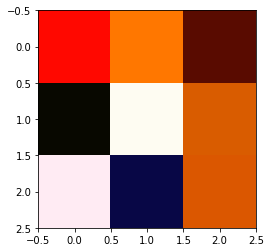

In [36]:
imshow(my_patch_resnet20_3x3_untargeted.cpu())

In [22]:
my_patch_resnet20_5x5_untargeted = train_patch(MODELS['Resnet20'].to(device), train_loader, None, device, (5,5))

Epoch Accuracy:  0.4350514311270125
Epoch Accuracy:  0.4229934681460272
Epoch Accuracy:  0.4235415175375805
Epoch Accuracy:  0.421998031496063
Epoch Accuracy:  0.42071179312813173
Epoch Accuracy:  0.4219532927702219
Epoch Accuracy:  0.4221658017179671
Epoch Accuracy:  0.4181169470293486
Epoch Accuracy:  0.4204433607730852
Epoch Accuracy:  0.42021966714387976


In [23]:
d_resnet20_5x5_untargeted = test_patch(MODELS['Resnet20'], test_loader, None, my_patch_resnet20_5x5_untargeted, device)

Model test accuracy: 0.79
Patch test accuracy: 0.00


-0.008553137102992103
1.0079711877100404


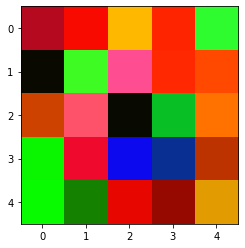

In [37]:
imshow(my_patch_resnet20_5x5_untargeted.cpu())

In [24]:
my_patch_resnet20_7x7_untargeted = train_patch(MODELS['Resnet20'].to(device), train_loader, None, device, (7,7))

Epoch Accuracy:  0.4034660107334526
Epoch Accuracy:  0.36893790264853255
Epoch Accuracy:  0.36379294917680743
Epoch Accuracy:  0.36745034001431637
Epoch Accuracy:  0.3658173765211167
Epoch Accuracy:  0.3645311381531854
Epoch Accuracy:  0.3634126700071582
Epoch Accuracy:  0.3600125268432355
Epoch Accuracy:  0.3598894953471725
Epoch Accuracy:  0.36568316034359344


In [25]:
d_resnet20_7x7_untargeted = test_patch(MODELS['Resnet20'], test_loader, None, my_patch_resnet20_7x7_untargeted, device)

Model test accuracy: 0.68
Patch test accuracy: 0.00


-0.004091556650805517
1.0046419498662162


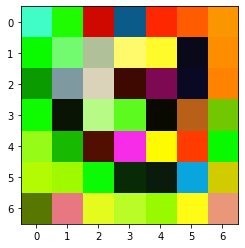

In [38]:
imshow(my_patch_resnet20_7x7_untargeted.cpu())

In [26]:
my_patch_resnet20_10x10_untargeted = train_patch(MODELS['Resnet20'].to(device), train_loader, None, device, (10,10))

Epoch Accuracy:  0.24646690518783543
Epoch Accuracy:  0.17728838582677164
Epoch Accuracy:  0.16522011453113816
Epoch Accuracy:  0.16121599856836077
Epoch Accuracy:  0.14903588045812455
Epoch Accuracy:  0.14679894416607014
Epoch Accuracy:  0.14912535790980672
Epoch Accuracy:  0.1442712061560487
Epoch Accuracy:  0.14339880100214747
Epoch Accuracy:  0.14173228346456693


In [27]:
d_resnet20_10x10_untargeted = test_patch(MODELS['Resnet20'], test_loader, None, my_patch_resnet20_10x10_untargeted, device)

Model test accuracy: 0.28
Patch test accuracy: 0.00


-0.0016017960492132333
1.0032072107969845


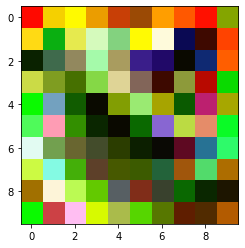

In [39]:
imshow(my_patch_resnet20_10x10_untargeted.cpu())

In [33]:
my_patch_resnet20_16x16_untargeted = train_patch(MODELS['Resnet20'].to(device), train_loader, None, device, (16,16))

Epoch Accuracy:  0.054964221824686944
Epoch Accuracy:  0.047680297065139585
Epoch Accuracy:  0.047221725125268434
Epoch Accuracy:  0.04699803149606299
Epoch Accuracy:  0.04705395490336435
Epoch Accuracy:  0.047009216177523266
Epoch Accuracy:  0.0469532927702219
Epoch Accuracy:  0.04690855404438082
Epoch Accuracy:  0.04691973872584109
Epoch Accuracy:  0.046886184681460275


In [34]:
d_resnet20_16x16_untargeted = test_patch(MODELS['Resnet20'], test_loader, None, my_patch_resnet20_16x16_untargeted, device)

Model test accuracy: 0.10
Patch test accuracy: 0.00


0.0947968971720709
0.7459889114606923


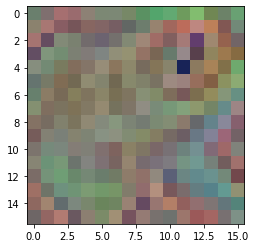

In [40]:
imshow(my_patch_resnet20_16x16_untargeted.cpu())

## Targeted Attacks on ResNet-20

In [ ]:
my_patch_resnet20_3x3_target_0 = train_patch(MODELS['Resnet20'].to(device), train_loader, 0, device, (3,3))

Epoch Accuracy:  0.463121254846669
Epoch Accuracy:  0.45729423686993304
Epoch Accuracy:  0.45591734226295383
Epoch Accuracy:  0.4546395840676771
Epoch Accuracy:  0.45592835741980964
Epoch Accuracy:  0.45526744800845964
Epoch Accuracy:  0.4569968276348255
Epoch Accuracy:  0.45737134296792387
Epoch Accuracy:  0.45582922100810713
Epoch Accuracy:  0.45621475149806134


In [ ]:
d_resnet20_3x3_target_0 = test_patch(MODELS['Resnet20'], test_loader, 0, my_patch_resnet20_3x3_target_0, device)

Model test accuracy: 0.83
Patch test accuracy: 0.05


In [ ]:
my_patch_resnet20_3x3_target_1 = train_patch(MODELS['Resnet20'].to(device), train_loader, 1, device, (3,3))

Epoch Accuracy:  0.470148085182534
Epoch Accuracy:  0.46190497494631355
Epoch Accuracy:  0.4600259484609878
Epoch Accuracy:  0.4617036506800286
Epoch Accuracy:  0.46162535790980674
Epoch Accuracy:  0.4623971009305655
Epoch Accuracy:  0.46105493915533285
Epoch Accuracy:  0.4610325697924123
Epoch Accuracy:  0.45933249821045097
Epoch Accuracy:  0.461882605583393


In [ ]:
d_resnet20_3x3_target_1 = test_patch(MODELS['Resnet20'], test_loader, 1, my_patch_resnet20_3x3_target_1, device)

Model test accuracy: 0.84
Patch test accuracy: 0.01


In [42]:
my_patch_resnet20_3x3_target_2 = train_patch(MODELS['Resnet20'].to(device), train_loader, 2, device, (3,3))

Epoch Accuracy:  0.4572621820136152
Epoch Accuracy:  0.4496484235041204
Epoch Accuracy:  0.4505217663919742
Epoch Accuracy:  0.4511599785023289
Epoch Accuracy:  0.45061134002149766
Epoch Accuracy:  0.4510256180580437
Epoch Accuracy:  0.4515518631314941
Epoch Accuracy:  0.4505217663919742
Epoch Accuracy:  0.45174220709423146
Epoch Accuracy:  0.45029783231816556


In [43]:
d_resnet20_3x3_target_2 = test_patch(MODELS['Resnet20'], test_loader, 2, my_patch_resnet20_3x3_target_2, device)

Model test accuracy: 0.83
Patch test accuracy: 0.07


-0.00622816356735395
1.0147829049486718


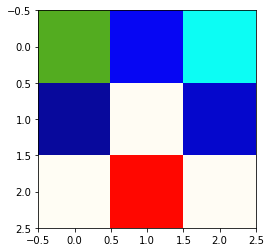

In [47]:
imshow(my_patch_resnet20_3x3_target_2.cpu())

In [ ]:
my_patch_resnet20_3x3_target_3 = train_patch(MODELS['Resnet20'].to(device), train_loader, 3, device, (3,3))

Epoch Accuracy:  0.4781829116179615
Epoch Accuracy:  0.4740845509622238
Epoch Accuracy:  0.47113328581610836
Epoch Accuracy:  0.4659657875980043
Epoch Accuracy:  0.46678991446899504
Epoch Accuracy:  0.46683446186742694
Epoch Accuracy:  0.4657541874554526
Epoch Accuracy:  0.46703492516037065
Epoch Accuracy:  0.4659991981468282
Epoch Accuracy:  0.4658321454027085


In [ ]:
d_resnet20_3x3_target_3 = test_patch(MODELS['Resnet20'], test_loader, 3, my_patch_resnet20_3x3_target_3, device)

Model test accuracy: 0.86
Patch test accuracy: 0.07


In [ ]:
my_patch_resnet20_3x3_target_4 = train_patch(MODELS['Resnet20'].to(device), train_loader, 4, device, (3,3))

Epoch Accuracy:  0.47117409617409617
Epoch Accuracy:  0.46488899613899615
Epoch Accuracy:  0.4668304668304668
Epoch Accuracy:  0.4643405580905581
Epoch Accuracy:  0.4661833099333099


In [ ]:
d_resnet20_3x3_target_4 = test_patch(MODELS['Resnet20'], test_loader, 4, my_patch_resnet20_3x3_target_4, device)

Model test accuracy: 0.86
Patch test accuracy: 0.02


In [ ]:
my_patch_resnet20_3x3_target_5 = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (3,3))

Epoch Accuracy:  0.47621945821529743
Epoch Accuracy:  0.46775407223796034
Epoch Accuracy:  0.46722291076487255
Epoch Accuracy:  0.46756595254957506
Epoch Accuracy:  0.4682962995750708
Epoch Accuracy:  0.4674995573654391
Epoch Accuracy:  0.46876106586402266
Epoch Accuracy:  0.46948034702549574
Epoch Accuracy:  0.46765447946175637
Epoch Accuracy:  0.46775407223796034


In [ ]:
d_resnet20_3x3_target_5 = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_3x3_target_5, device)

Model test accuracy: 0.86
Patch test accuracy: 0.04


In [ ]:
my_patch_resnet20_3x3_target_6 = train_patch(MODELS['Resnet20'].to(device), train_loader, 6, device, (3,3))

Epoch Accuracy:  0.4755838403722262
Epoch Accuracy:  0.46630055476020044
Epoch Accuracy:  0.4653722261989979
Epoch Accuracy:  0.4640412491052255
Epoch Accuracy:  0.4639965103793844
Epoch Accuracy:  0.4652268253400143
Epoch Accuracy:  0.46444389763779526
Epoch Accuracy:  0.4645445597709377
Epoch Accuracy:  0.46585316750178957
Epoch Accuracy:  0.46514853256979244


In [ ]:
d_resnet20_3x3_target_6 = test_patch(MODELS['Resnet20'], test_loader, 6, my_patch_resnet20_3x3_target_6, device)

Model test accuracy: 0.86
Patch test accuracy: 0.00


In [ ]:
my_patch_resnet20_3x3_target_7 = train_patch(MODELS['Resnet20'].to(device), train_loader, 7, device, (3,3))

Epoch Accuracy:  0.4732444820220719
Epoch Accuracy:  0.46661400854396584
Epoch Accuracy:  0.46620238519045926
Epoch Accuracy:  0.46671413314346744
Epoch Accuracy:  0.466313634745461
Epoch Accuracy:  0.4658018867924528
Epoch Accuracy:  0.4659242613029548
Epoch Accuracy:  0.4671480064079744
Epoch Accuracy:  0.46636925952296193
Epoch Accuracy:  0.466936632253471


In [ ]:
d_resnet20_3x3_target_7 = test_patch(MODELS['Resnet20'], test_loader, 7, my_patch_resnet20_3x3_target_7, device)

Model test accuracy: 0.86
Patch test accuracy: 0.01


In [ ]:
my_patch_resnet20_3x3_target_8 = train_patch(MODELS['Resnet20'].to(device), train_loader, 8, device, (3,3))

Epoch Accuracy:  0.47931510509440683
Epoch Accuracy:  0.471332828642679
Epoch Accuracy:  0.47086524759529746
Epoch Accuracy:  0.4710322408265052
Epoch Accuracy:  0.4696740292126826
Epoch Accuracy:  0.4702640719629498
Epoch Accuracy:  0.4707205201282508
Epoch Accuracy:  0.4686052725329533
Epoch Accuracy:  0.4688279301745636
Epoch Accuracy:  0.4694179729248308


In [ ]:
d_resnet20_3x3_target_8 = test_patch(MODELS['Resnet20'], test_loader, 8, my_patch_resnet20_3x3_target_8, device)

Model test accuracy: 0.87
Patch test accuracy: 0.00


In [ ]:
my_patch_resnet20_3x3_target_9 = train_patch(MODELS['Resnet20'].to(device), train_loader, 9, device, (3,3))

Epoch Accuracy:  0.47450248756218905
Epoch Accuracy:  0.46378598081023453
Epoch Accuracy:  0.4652629708599858
Epoch Accuracy:  0.4660625444207534
Epoch Accuracy:  0.4653518123667377
Epoch Accuracy:  0.46589596659559346
Epoch Accuracy:  0.464863184079602
Epoch Accuracy:  0.46650675195451313
Epoch Accuracy:  0.4646410803127221
Epoch Accuracy:  0.4663623845060412


In [ ]:
d_resnet20_3x3_target_9 = test_patch(MODELS['Resnet20'], test_loader, 9, my_patch_resnet20_3x3_target_9, device)

Model test accuracy: 0.85
Patch test accuracy: 0.01


In [ ]:
my_patch_resnet20_5x5_target_0 = train_patch(MODELS['Resnet20'].to(device), train_loader, 0, device, (5,5))

Epoch Accuracy:  0.424920690870638
Epoch Accuracy:  0.39402317589002467
Epoch Accuracy:  0.3919302960874163
Epoch Accuracy:  0.39017888614733875
Epoch Accuracy:  0.3891544765597462
Epoch Accuracy:  0.38453912583715194
Epoch Accuracy:  0.38904432499118785
Epoch Accuracy:  0.38868082481494537
Epoch Accuracy:  0.3897052344025379
Epoch Accuracy:  0.38858168840324286


In [ ]:
d_resnet20_5x5_target_0 = test_patch(MODELS['Resnet20'], test_loader, 0, my_patch_resnet20_5x5_target_0, device)

Model test accuracy: 0.69
Patch test accuracy: 0.13


In [ ]:
my_patch_resnet20_5x5_target_1 = train_patch(MODELS['Resnet20'].to(device), train_loader, 1, device, (5,5))

Epoch Accuracy:  0.4231947924123121
Epoch Accuracy:  0.3927836435218325
Epoch Accuracy:  0.39108357193987114
Epoch Accuracy:  0.3944389763779528
Epoch Accuracy:  0.38951771653543305
Epoch Accuracy:  0.39345472440944884
Epoch Accuracy:  0.38997628847530424
Epoch Accuracy:  0.3925711345740873
Epoch Accuracy:  0.3947297780959198
Epoch Accuracy:  0.3940586972083035


In [ ]:
d_resnet20_5x5_target_1 = test_patch(MODELS['Resnet20'], test_loader, 1, my_patch_resnet20_5x5_target_1, device)

Model test accuracy: 0.70
Patch test accuracy: 0.06


In [ ]:
my_patch_resnet20_5x5_target_2 = train_patch(MODELS['Resnet20'].to(device), train_loader, 2, device, (5,5))

Epoch Accuracy:  0.4238736116087424
Epoch Accuracy:  0.40473844500179146
Epoch Accuracy:  0.39765093156574705
Epoch Accuracy:  0.39732622715872445
Epoch Accuracy:  0.3960609996417055
Epoch Accuracy:  0.39495252597635255
Epoch Accuracy:  0.39668801504836976
Epoch Accuracy:  0.3956915084199212
Epoch Accuracy:  0.38789860265137943
Epoch Accuracy:  0.3891190433536367


In [ ]:
d_resnet20_5x5_target_2 = test_patch(MODELS['Resnet20'], test_loader, 2, my_patch_resnet20_5x5_target_2, device)

Model test accuracy: 0.68
Patch test accuracy: 0.20


In [ ]:
my_patch_resnet20_5x5_target_3 = train_patch(MODELS['Resnet20'].to(device), train_loader, 3, device, (5,5))

Epoch Accuracy:  0.40295349251603707
Epoch Accuracy:  0.3836533321454027
Epoch Accuracy:  0.379554971489665
Epoch Accuracy:  0.3806797933000713
Epoch Accuracy:  0.3803902352102637
Epoch Accuracy:  0.3804681931575196
Epoch Accuracy:  0.382172131147541
Epoch Accuracy:  0.38210531004989307
Epoch Accuracy:  0.3797442979330007
Epoch Accuracy:  0.3826732893799002


In [ ]:
d_resnet20_5x5_target_3 = test_patch(MODELS['Resnet20'], test_loader, 3, my_patch_resnet20_5x5_target_3, device)

Model test accuracy: 0.68
Patch test accuracy: 0.28


In [ ]:
my_patch_resnet20_5x5_target_4 = train_patch(MODELS['Resnet20'].to(device), train_loader, 4, device, (5,5))

Epoch Accuracy:  0.4577922077922078
Epoch Accuracy:  0.4502895752895753
Epoch Accuracy:  0.44900623025623027
Epoch Accuracy:  0.44787644787644787
Epoch Accuracy:  0.44720735345735346
Epoch Accuracy:  0.4479203229203229
Epoch Accuracy:  0.44704282204282203
Epoch Accuracy:  0.4467905405405405
Epoch Accuracy:  0.44552913302913305
Epoch Accuracy:  0.44742672867672867


In [ ]:
d_resnet20_5x5_target_4 = test_patch(MODELS['Resnet20'], test_loader, 4, my_patch_resnet20_5x5_target_4, device)

Model test accuracy: 0.82
Patch test accuracy: 0.06


In [44]:
my_patch_resnet20_5x5_target_5 = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (5,5))

Epoch Accuracy:  0.35120839235127477
Epoch Accuracy:  0.3249822946175637
Epoch Accuracy:  0.3209875177053824
Epoch Accuracy:  0.31990306303116145
Epoch Accuracy:  0.3248163066572238
Epoch Accuracy:  0.32115350566572237
Epoch Accuracy:  0.3215076133144476
Epoch Accuracy:  0.3188075424929179
Epoch Accuracy:  0.32158507436260625
Epoch Accuracy:  0.31898459631728043


In [45]:
d_resnet20_5x5_target_5 = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_5x5_target_5, device)

Model test accuracy: 0.57
Patch test accuracy: 0.40


-0.003949780357723143
1.0120410624542662


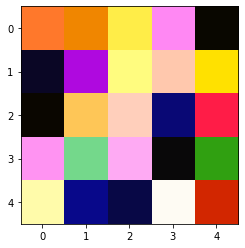

In [48]:
imshow(my_patch_resnet20_5x5_target_5.cpu())

In [ ]:
my_patch_resnet20_5x5_target_6 = train_patch(MODELS['Resnet20'].to(device), train_loader, 6, device, (5,5))

Epoch Accuracy:  0.4594107909806729
Epoch Accuracy:  0.43548675733715103
Epoch Accuracy:  0.43503937007874016
Epoch Accuracy:  0.432936649964209
Epoch Accuracy:  0.4327353256979241
Epoch Accuracy:  0.43261229420186115
Epoch Accuracy:  0.4325116320687187
Epoch Accuracy:  0.432936649964209
Epoch Accuracy:  0.43142671796707227
Epoch Accuracy:  0.4324668933428776


In [ ]:
d_resnet20_5x5_target_6 = test_patch(MODELS['Resnet20'], test_loader, 6, my_patch_resnet20_5x5_target_6, device)

Model test accuracy: 0.79
Patch test accuracy: 0.04


In [ ]:
my_patch_resnet20_5x5_target_7 = train_patch(MODELS['Resnet20'].to(device), train_loader, 7, device, (5,5))

Epoch Accuracy:  0.47263260946956215
Epoch Accuracy:  0.43372864008543965
Epoch Accuracy:  0.4254627981488074
Epoch Accuracy:  0.4213020647917408
Epoch Accuracy:  0.42010056959772163
Epoch Accuracy:  0.42149118903524385
Epoch Accuracy:  0.42073469206123176
Epoch Accuracy:  0.4186988252046992
Epoch Accuracy:  0.41612896048415804
Epoch Accuracy:  0.4175863296546814


In [ ]:
d_resnet20_5x5_target_7 = test_patch(MODELS['Resnet20'], test_loader, 7, my_patch_resnet20_5x5_target_7, device)

Model test accuracy: 0.78
Patch test accuracy: 0.00


In [ ]:
my_patch_resnet20_5x5_target_8 = train_patch(MODELS['Resnet20'].to(device), train_loader, 8, device, (5,5))

Epoch Accuracy:  0.4530192376202351
Epoch Accuracy:  0.4305642144638404
Epoch Accuracy:  0.42898334520840753
Epoch Accuracy:  0.42557668329177056
Epoch Accuracy:  0.42495324189526185
Epoch Accuracy:  0.42262646954043465
Epoch Accuracy:  0.419075080156751
Epoch Accuracy:  0.4200993053081582
Epoch Accuracy:  0.4190305486284289
Epoch Accuracy:  0.4192198076237976


In [ ]:
d_resnet20_5x5_target_8 = test_patch(MODELS['Resnet20'], test_loader, 8, my_patch_resnet20_5x5_target_8, device)

Model test accuracy: 0.77
Patch test accuracy: 0.00


In [ ]:
my_patch_resnet20_5x5_target_9 = train_patch(MODELS['Resnet20'].to(device), train_loader, 9, device, (5,5))

Epoch Accuracy:  0.4510150142146411
Epoch Accuracy:  0.44742803837953093
Epoch Accuracy:  0.44846082089552236
Epoch Accuracy:  0.44692830490405117
Epoch Accuracy:  0.44600657427149965
Epoch Accuracy:  0.44758351101634686
Epoch Accuracy:  0.4478056147832267
Epoch Accuracy:  0.44636194029850745
Epoch Accuracy:  0.4466950959488273
Epoch Accuracy:  0.4463508351101635


In [ ]:
d_resnet20_5x5_target_9 = test_patch(MODELS['Resnet20'], test_loader, 9, my_patch_resnet20_5x5_target_9, device)

Model test accuracy: 0.81
Patch test accuracy: 0.04


In [ ]:
my_patch_resnet20_7x7_target_0 = train_patch(MODELS['Resnet20'].to(device), train_loader, 0, device, (7,7))

Epoch Accuracy:  0.4214178709904829
Epoch Accuracy:  0.38976031018681706
Epoch Accuracy:  0.38687433909058866
Epoch Accuracy:  0.3855745505816003
Epoch Accuracy:  0.38156503348607684
Epoch Accuracy:  0.37194880155093407
Epoch Accuracy:  0.36353322171307717
Epoch Accuracy:  0.3599973563623546
Epoch Accuracy:  0.36214531194924215
Epoch Accuracy:  0.3588738103630596


In [ ]:
d_resnet20_7x7_target_0 = test_patch(MODELS['Resnet20'], test_loader, 0, my_patch_resnet20_7x7_target_0, device)

Model test accuracy: 0.63
Patch test accuracy: 0.23


In [ ]:
my_patch_resnet20_7x7_target_1 = train_patch(MODELS['Resnet20'].to(device), train_loader, 1, device, (7,7))

Epoch Accuracy:  0.41981701861130993
Epoch Accuracy:  0.3768119183965641
Epoch Accuracy:  0.37140971725125266
Epoch Accuracy:  0.3614553507516106
Epoch Accuracy:  0.36643253400143166
Epoch Accuracy:  0.3659068539727989
Epoch Accuracy:  0.36811023622047245
Epoch Accuracy:  0.3634797780959198
Epoch Accuracy:  0.3665667501789549
Epoch Accuracy:  0.3692734430923407


In [ ]:
d_resnet20_7x7_target_1 = test_patch(MODELS['Resnet20'], test_loader, 1, my_patch_resnet20_7x7_target_1, device)

Model test accuracy: 0.65
Patch test accuracy: 0.21


In [ ]:
my_patch_resnet20_7x7_target_2 = train_patch(MODELS['Resnet20'].to(device), train_loader, 2, device, (7,7))

Epoch Accuracy:  0.3478927803654604
Epoch Accuracy:  0.3117722142601218
Epoch Accuracy:  0.30949928341096383
Epoch Accuracy:  0.313171802221426
Epoch Accuracy:  0.3062298459333572
Epoch Accuracy:  0.30577078108204947
Epoch Accuracy:  0.3069240415621641
Epoch Accuracy:  0.30289322823360804
Epoch Accuracy:  0.3057819777857399
Epoch Accuracy:  0.30423683267646007


In [ ]:
d_resnet20_7x7_target_2 = test_patch(MODELS['Resnet20'], test_loader, 2, my_patch_resnet20_7x7_target_2, device)

Model test accuracy: 0.53
Patch test accuracy: 0.42


In [ ]:
my_patch_resnet20_7x7_target_3 = train_patch(MODELS['Resnet20'].to(device), train_loader, 3, device, (7,7))

Epoch Accuracy:  0.4398944226657163
Epoch Accuracy:  0.4227770848182466
Epoch Accuracy:  0.41269823592302207
Epoch Accuracy:  0.4085219173200285
Epoch Accuracy:  0.3983539736279401
Epoch Accuracy:  0.39477904490377763
Epoch Accuracy:  0.38880969351389877
Epoch Accuracy:  0.39006815751960083
Epoch Accuracy:  0.38798556664290806
Epoch Accuracy:  0.38780737704918034


In [ ]:
d_resnet20_7x7_target_3 = test_patch(MODELS['Resnet20'], test_loader, 3, my_patch_resnet20_7x7_target_3, device)

Model test accuracy: 0.71
Patch test accuracy: 0.13


In [ ]:
my_patch_resnet20_7x7_target_4 = train_patch(MODELS['Resnet20'].to(device), train_loader, 4, device, (7,7))

Epoch Accuracy:  0.3863197613197613
Epoch Accuracy:  0.3593366093366093
Epoch Accuracy:  0.35548657423657426
Epoch Accuracy:  0.35500394875394875
Epoch Accuracy:  0.3517242892242892
Epoch Accuracy:  0.3492343804843805
Epoch Accuracy:  0.3510222885222885
Epoch Accuracy:  0.352009477009477
Epoch Accuracy:  0.34752325377325377
Epoch Accuracy:  0.34716128466128465


In [ ]:
d_resnet20_7x7_target_4 = test_patch(MODELS['Resnet20'], test_loader, 4, my_patch_resnet20_7x7_target_4, device)

Model test accuracy: 0.63
Patch test accuracy: 0.30


In [49]:
my_patch_resnet20_7x7_target_5 = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (7,7))

Epoch Accuracy:  0.42945511685552407
Epoch Accuracy:  0.29830249645892354
Epoch Accuracy:  0.2599924752124646
Epoch Accuracy:  0.2199451133144476
Epoch Accuracy:  0.2024389164305949
Epoch Accuracy:  0.1910189447592068
Epoch Accuracy:  0.1820998583569405
Epoch Accuracy:  0.18161296033994334
Epoch Accuracy:  0.18390359419263455
Epoch Accuracy:  0.1829076664305949


In [50]:
d_resnet20_7x7_target_5 = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_7x7_target_5, device)

Model test accuracy: 0.29
Patch test accuracy: 0.71


-0.0016339789620880563
1.0038651320546925


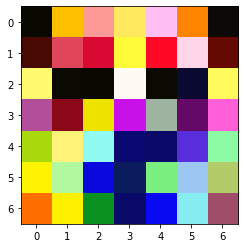

In [51]:
imshow(my_patch_resnet20_7x7_target_5.cpu())

In [ ]:
my_patch_resnet20_7x7_target_6 = train_patch(MODELS['Resnet20'].to(device), train_loader, 6, device, (7,7))

Epoch Accuracy:  0.44535164638511093
Epoch Accuracy:  0.4360124373657838
Epoch Accuracy:  0.41834064065855403
Epoch Accuracy:  0.37506710808876165
Epoch Accuracy:  0.37082811381531855
Epoch Accuracy:  0.3666450429491768
Epoch Accuracy:  0.3661864710093057
Epoch Accuracy:  0.3670812455261274
Epoch Accuracy:  0.3673832319255548
Epoch Accuracy:  0.36188036864710094


In [ ]:
d_resnet20_7x7_target_6 = test_patch(MODELS['Resnet20'], test_loader, 6, my_patch_resnet20_7x7_target_6, device)

Model test accuracy: 0.66
Patch test accuracy: 0.23


In [ ]:
my_patch_resnet20_7x7_target_7 = train_patch(MODELS['Resnet20'].to(device), train_loader, 7, device, (7,7))

Epoch Accuracy:  0.45378693485226057
Epoch Accuracy:  0.4396916162335351
Epoch Accuracy:  0.43479663581345673
Epoch Accuracy:  0.43201539693841223
Epoch Accuracy:  0.4289115343538626
Epoch Accuracy:  0.429812655749377
Epoch Accuracy:  0.43025765396938415
Epoch Accuracy:  0.4283552865788537
Epoch Accuracy:  0.42650854396582416
Epoch Accuracy:  0.4286000355998576


In [ ]:
d_resnet20_7x7_target_7 = test_patch(MODELS['Resnet20'], test_loader, 7, my_patch_resnet20_7x7_target_7, device)

Model test accuracy: 0.78
Patch test accuracy: 0.08


In [ ]:
my_patch_resnet20_7x7_target_8 = train_patch(MODELS['Resnet20'].to(device), train_loader, 8, device, (7,7))

Epoch Accuracy:  0.44662896330602064
Epoch Accuracy:  0.42841556822230137
Epoch Accuracy:  0.4259663341645885
Epoch Accuracy:  0.4248307801923762
Epoch Accuracy:  0.4253317598859993
Epoch Accuracy:  0.4217358389739936
Epoch Accuracy:  0.42324991093694336
Epoch Accuracy:  0.421680174563591
Epoch Accuracy:  0.42074501246882795
Epoch Accuracy:  0.4219918952618454


In [ ]:
d_resnet20_7x7_target_8 = test_patch(MODELS['Resnet20'], test_loader, 8, my_patch_resnet20_7x7_target_8, device)

Model test accuracy: 0.77
Patch test accuracy: 0.09


In [ ]:
my_patch_resnet20_7x7_target_9 = train_patch(MODELS['Resnet20'].to(device), train_loader, 9, device, (7,7))

Epoch Accuracy:  0.41673329779673063
Epoch Accuracy:  0.3923685145700071
Epoch Accuracy:  0.38567208599857855
Epoch Accuracy:  0.3832289445628998
Epoch Accuracy:  0.37505552594172
Epoch Accuracy:  0.3664378997867804
Epoch Accuracy:  0.36648232054015634
Epoch Accuracy:  0.3640724946695096
Epoch Accuracy:  0.36358386638237383
Epoch Accuracy:  0.3629175550817342


In [ ]:
d_resnet20_7x7_target_9 = test_patch(MODELS['Resnet20'], test_loader, 9, my_patch_resnet20_7x7_target_9, device)

Model test accuracy: 0.65
Patch test accuracy: 0.26


In [ ]:
my_patch_resnet20_16x16_target_0 = train_patch(MODELS['Resnet20'].to(device), train_loader, 0, device, (16,16))

Epoch Accuracy:  0.06272030313711667
Epoch Accuracy:  0.05047144871342968
Epoch Accuracy:  0.04916064504758548
Epoch Accuracy:  0.049116584420162146
Epoch Accuracy:  0.04825740218540712
Epoch Accuracy:  0.04819131124427212
Epoch Accuracy:  0.04814725061684878
Epoch Accuracy:  0.04780578075431794
Epoch Accuracy:  0.04798202326401128
Epoch Accuracy:  0.047849841381741275


In [ ]:
d_resnet20_16x16_target_0 = test_patch(MODELS['Resnet20'], test_loader, 0, my_patch_resnet20_16x16_target_0, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [ ]:
my_patch_resnet20_16x16_target_1 = train_patch(MODELS['Resnet20'].to(device), train_loader, 1, device, (16,16))

Epoch Accuracy:  0.05793664996420902
Epoch Accuracy:  0.04924615246957767
Epoch Accuracy:  0.04781451324266285
Epoch Accuracy:  0.047758589835361485
Epoch Accuracy:  0.04725527916964925
Epoch Accuracy:  0.04718817108088762
Epoch Accuracy:  0.04699803149606299
Epoch Accuracy:  0.04693092340730136
Epoch Accuracy:  0.046863815318539725
Epoch Accuracy:  0.046886184681460275


In [ ]:
d_resnet20_16x16_target_1 = test_patch(MODELS['Resnet20'], test_loader, 1, my_patch_resnet20_16x16_target_1, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [ ]:
my_patch_resnet20_16x16_target_2 = train_patch(MODELS['Resnet20'].to(device), train_loader, 2, device, (16,16))

Epoch Accuracy:  0.05056431386599785
Epoch Accuracy:  0.04712692583303475
Epoch Accuracy:  0.04702615549982085
Epoch Accuracy:  0.04689179505553565
Epoch Accuracy:  0.04680222142601218
Epoch Accuracy:  0.04675743461125045
Epoch Accuracy:  0.046768631314940884
Epoch Accuracy:  0.046779828018631314
Epoch Accuracy:  0.046768631314940884
Epoch Accuracy:  0.046746237907560016


In [ ]:
d_resnet20_16x16_target_2 = test_patch(MODELS['Resnet20'], test_loader, 2, my_patch_resnet20_16x16_target_2, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [ ]:
my_patch_resnet20_16x16_target_3 = train_patch(MODELS['Resnet20'].to(device), train_loader, 3, device, (16,16))

Epoch Accuracy:  0.0510401817533856
Epoch Accuracy:  0.047465253029223095
Epoch Accuracy:  0.0471979686386315
Epoch Accuracy:  0.04712001069137562
Epoch Accuracy:  0.0470086421952958
Epoch Accuracy:  0.04706432644333571
Epoch Accuracy:  0.046964094796863864
Epoch Accuracy:  0.04690841054882395
Epoch Accuracy:  0.04686386315039202
Epoch Accuracy:  0.04691954739843193


In [ ]:
d_resnet20_16x16_target_3 = test_patch(MODELS['Resnet20'], test_loader, 3, my_patch_resnet20_16x16_target_3, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [ ]:
my_patch_resnet20_16x16_target_4 = train_patch(MODELS['Resnet20'].to(device), train_loader, 4, device, (16,16))

Epoch Accuracy:  0.056675587925587925
Epoch Accuracy:  0.04826254826254826
Epoch Accuracy:  0.048174798174798174
Epoch Accuracy:  0.048087048087048084
Epoch Accuracy:  0.04792251667251667
Epoch Accuracy:  0.047966391716391714
Epoch Accuracy:  0.04798832923832924
Epoch Accuracy:  0.047999297999298
Epoch Accuracy:  0.04783476658476658
Epoch Accuracy:  0.04782379782379782


In [ ]:
d_resnet20_16x16_target_4 = test_patch(MODELS['Resnet20'], test_loader, 4, my_patch_resnet20_16x16_target_4, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [ ]:
my_patch_resnet20_16x16_target_5 = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (16,16))

Epoch Accuracy:  0.062367209631728045
Epoch Accuracy:  0.04760534702549575
Epoch Accuracy:  0.04749468838526912
Epoch Accuracy:  0.04733976628895184
Epoch Accuracy:  0.04718484419263456
Epoch Accuracy:  0.04718484419263456
Epoch Accuracy:  0.04712951487252125
Epoch Accuracy:  0.04718484419263456
Epoch Accuracy:  0.04714058073654391
Epoch Accuracy:  0.047118449008498584


In [ ]:
d_resnet20_16x16_target_5 = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_16x16_target_5, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [ ]:
my_patch_resnet20_16x16_target_6 = train_patch(MODELS['Resnet20'].to(device), train_loader, 6, device, (16,16))

Epoch Accuracy:  0.052735773085182534
Epoch Accuracy:  0.04731120257695061
Epoch Accuracy:  0.04704277022190408
Epoch Accuracy:  0.04690855404438082
Epoch Accuracy:  0.04694210808876163
Epoch Accuracy:  0.04676315318539728
Epoch Accuracy:  0.04681907659269864
Epoch Accuracy:  0.04670722977809592
Epoch Accuracy:  0.04681907659269864
Epoch Accuracy:  0.04685263063707946


In [ ]:
d_resnet20_16x16_target_6 = test_patch(MODELS['Resnet20'], test_loader, 6, my_patch_resnet20_16x16_target_6, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [ ]:
my_patch_resnet20_16x16_target_7 = train_patch(MODELS['Resnet20'].to(device), train_loader, 7, device, (16,16))

Epoch Accuracy:  0.060141509433962265
Epoch Accuracy:  0.048226682093271626
Epoch Accuracy:  0.04799305802776789
Epoch Accuracy:  0.04769268422926308
Epoch Accuracy:  0.04764818440726237
Epoch Accuracy:  0.04750355998576006
Epoch Accuracy:  0.04723656105375579
Epoch Accuracy:  0.047403435386258456
Epoch Accuracy:  0.047481310074759704
Epoch Accuracy:  0.04724768600925596


In [ ]:
d_resnet20_16x16_target_7 = test_patch(MODELS['Resnet20'], test_loader, 7, my_patch_resnet20_16x16_target_7, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


In [52]:
my_patch_resnet20_16x16_target_8 = train_patch(MODELS['Resnet20'].to(device), train_loader, 8, device, (16,16))

Epoch Accuracy:  0.07896553259707874
Epoch Accuracy:  0.058837281795511225
Epoch Accuracy:  0.055653277520484504
Epoch Accuracy:  0.05460678660491628
Epoch Accuracy:  0.0529145885286783
Epoch Accuracy:  0.05226888136800855
Epoch Accuracy:  0.05153411115069469
Epoch Accuracy:  0.05101086569291058
Epoch Accuracy:  0.051311453509084434
Epoch Accuracy:  0.05072141075881724


In [53]:
d_resnet20_16x16_target_8 = test_patch(MODELS['Resnet20'], test_loader, 8, my_patch_resnet20_16x16_target_8, device)

Model test accuracy: 0.01
Patch test accuracy: 0.99


0.03922814935560198
1.0000393613948781


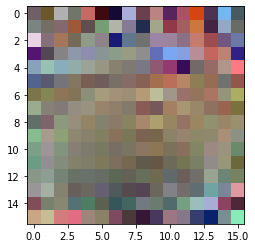

In [54]:
imshow(my_patch_resnet20_16x16_target_8.cpu())

In [ ]:
my_patch_resnet20_16x16_target_9 = train_patch(MODELS['Resnet20'].to(device), train_loader, 9, device, (16,16))

Epoch Accuracy:  0.056669776119402986
Epoch Accuracy:  0.048829513148543
Epoch Accuracy:  0.04814099147121535
Epoch Accuracy:  0.04826314854299929
Epoch Accuracy:  0.04799662402274343
Epoch Accuracy:  0.04790778251599147
Epoch Accuracy:  0.04779673063255153
Epoch Accuracy:  0.047707889125799575
Epoch Accuracy:  0.04778562544420754
Epoch Accuracy:  0.047718994314143566


In [ ]:
d_resnet20_16x16_target_9 = test_patch(MODELS['Resnet20'], test_loader, 9, my_patch_resnet20_16x16_target_9, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


## Percentage of Training Set Tests

### Training Size = 4000

In [62]:
my_patch_resnet20_3x3_target_5_1k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (3,3))

Epoch Accuracy:  0.462
Epoch Accuracy:  0.45825
Epoch Accuracy:  0.45975
Epoch Accuracy:  0.4615
Epoch Accuracy:  0.45675
Epoch Accuracy:  0.461
Epoch Accuracy:  0.46375
Epoch Accuracy:  0.4555
Epoch Accuracy:  0.46225
Epoch Accuracy:  0.459


In [63]:
d_resnet20_3x3_target_5_1k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_3x3_target_5_1k_tsz, device)

Model test accuracy: 0.85
Patch test accuracy: 0.06


In [64]:
my_patch_resnet20_7x7_target_5_1k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (7,7))

Epoch Accuracy:  0.243
Epoch Accuracy:  0.187
Epoch Accuracy:  0.195
Epoch Accuracy:  0.18125
Epoch Accuracy:  0.17175
Epoch Accuracy:  0.18625
Epoch Accuracy:  0.1845
Epoch Accuracy:  0.18675
Epoch Accuracy:  0.1885
Epoch Accuracy:  0.1815


In [65]:
d_resnet20_7x7_target_5_1k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_7x7_target_5_1k_tsz, device)

Model test accuracy: 0.30
Patch test accuracy: 0.69


In [66]:
my_patch_resnet20_10x10_target_5_1k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (10,10))

Epoch Accuracy:  0.14075
Epoch Accuracy:  0.07775
Epoch Accuracy:  0.07125
Epoch Accuracy:  0.06425
Epoch Accuracy:  0.06
Epoch Accuracy:  0.0605
Epoch Accuracy:  0.06075
Epoch Accuracy:  0.05875
Epoch Accuracy:  0.0535
Epoch Accuracy:  0.056


In [67]:
d_resnet20_10x10_target_5_1k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_10x10_target_5_1k_tsz, device)

Model test accuracy: 0.05
Patch test accuracy: 0.95


In [68]:
my_patch_resnet20_16x16_target_5_1k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (16,16))

Epoch Accuracy:  0.0445
Epoch Accuracy:  0.036
Epoch Accuracy:  0.03575
Epoch Accuracy:  0.036
Epoch Accuracy:  0.03575
Epoch Accuracy:  0.03625
Epoch Accuracy:  0.03575
Epoch Accuracy:  0.036
Epoch Accuracy:  0.036
Epoch Accuracy:  0.036


In [69]:
d_resnet20_16x16_target_5_1k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_16x16_target_5_1k_tsz, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


### Training Size == 8000

In [71]:
my_patch_resnet20_3x3_target_5_2k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (3,3))

Epoch Accuracy:  0.469375
Epoch Accuracy:  0.466375
Epoch Accuracy:  0.46525
Epoch Accuracy:  0.464875
Epoch Accuracy:  0.4625
Epoch Accuracy:  0.46225
Epoch Accuracy:  0.463625
Epoch Accuracy:  0.46425
Epoch Accuracy:  0.46275
Epoch Accuracy:  0.46125


In [72]:
d_resnet20_3x3_target_5_2k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_3x3_target_5_1k_tsz, device)

Model test accuracy: 0.85
Patch test accuracy: 0.06


In [73]:
my_patch_resnet20_7x7_target_5_2k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (7,7))

Epoch Accuracy:  0.22175
Epoch Accuracy:  0.157375
Epoch Accuracy:  0.160625
Epoch Accuracy:  0.155875
Epoch Accuracy:  0.158625
Epoch Accuracy:  0.155875
Epoch Accuracy:  0.15575
Epoch Accuracy:  0.1585
Epoch Accuracy:  0.15675
Epoch Accuracy:  0.1515


In [74]:
d_resnet20_7x7_target_5_2k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_7x7_target_5_1k_tsz, device)

Model test accuracy: 0.31
Patch test accuracy: 0.68


In [75]:
my_patch_resnet20_10x10_target_5_2k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (10,10))

Epoch Accuracy:  0.181375
Epoch Accuracy:  0.088375
Epoch Accuracy:  0.078125
Epoch Accuracy:  0.074625
Epoch Accuracy:  0.064375
Epoch Accuracy:  0.062
Epoch Accuracy:  0.06275
Epoch Accuracy:  0.057375
Epoch Accuracy:  0.05675
Epoch Accuracy:  0.05325


In [76]:
d_resnet20_10x10_target_5_2k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_10x10_target_5_1k_tsz, device)

Model test accuracy: 0.05
Patch test accuracy: 0.95


In [77]:
my_patch_resnet20_16x16_target_5_2k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (16,16))

Epoch Accuracy:  0.045625
Epoch Accuracy:  0.03525
Epoch Accuracy:  0.03525
Epoch Accuracy:  0.034875
Epoch Accuracy:  0.03475
Epoch Accuracy:  0.034875
Epoch Accuracy:  0.03475
Epoch Accuracy:  0.034875
Epoch Accuracy:  0.035125
Epoch Accuracy:  0.034625


In [78]:
d_resnet20_16x16_target_5_2k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_16x16_target_5_1k_tsz, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


### Training Size == 20000

In [80]:
my_patch_resnet20_3x3_target_5_5k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (3,3))

Epoch Accuracy:  0.4657
Epoch Accuracy:  0.4631
Epoch Accuracy:  0.46635
Epoch Accuracy:  0.46315
Epoch Accuracy:  0.46395
Epoch Accuracy:  0.4644
Epoch Accuracy:  0.4625
Epoch Accuracy:  0.46415
Epoch Accuracy:  0.4653
Epoch Accuracy:  0.46225


In [81]:
d_resnet20_3x3_target_5_5k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_3x3_target_5_1k_tsz, device)

Model test accuracy: 0.84
Patch test accuracy: 0.06


In [82]:
my_patch_resnet20_7x7_target_5_5k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (7,7))

Epoch Accuracy:  0.19095
Epoch Accuracy:  0.1652
Epoch Accuracy:  0.16285
Epoch Accuracy:  0.1596
Epoch Accuracy:  0.164
Epoch Accuracy:  0.1551
Epoch Accuracy:  0.1521
Epoch Accuracy:  0.15715
Epoch Accuracy:  0.15495
Epoch Accuracy:  0.1537


In [83]:
d_resnet20_7x7_target_5_5k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_7x7_target_5_1k_tsz, device)

Model test accuracy: 0.31
Patch test accuracy: 0.68


In [84]:
my_patch_resnet20_10x10_target_5_5k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (10,10))

Epoch Accuracy:  0.0712
Epoch Accuracy:  0.0533
Epoch Accuracy:  0.05145
Epoch Accuracy:  0.0487
Epoch Accuracy:  0.04815
Epoch Accuracy:  0.0475
Epoch Accuracy:  0.04715
Epoch Accuracy:  0.04605
Epoch Accuracy:  0.04705
Epoch Accuracy:  0.04775


In [85]:
d_resnet20_10x10_target_5_5k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_10x10_target_5_1k_tsz, device)

Model test accuracy: 0.05
Patch test accuracy: 0.95


In [86]:
my_patch_resnet20_16x16_target_5_5k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (16,16))

Epoch Accuracy:  0.0386
Epoch Accuracy:  0.03475
Epoch Accuracy:  0.03475
Epoch Accuracy:  0.0347
Epoch Accuracy:  0.03465
Epoch Accuracy:  0.0347
Epoch Accuracy:  0.03465
Epoch Accuracy:  0.03465
Epoch Accuracy:  0.0347
Epoch Accuracy:  0.03465


In [87]:
d_resnet20_16x16_target_5_5k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_16x16_target_5_1k_tsz, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


### Training Size == 40000

In [89]:
my_patch_resnet20_3x3_target_5_10k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (3,3))

Epoch Accuracy:  0.465675
Epoch Accuracy:  0.465875
Epoch Accuracy:  0.464525
Epoch Accuracy:  0.4656
Epoch Accuracy:  0.465675
Epoch Accuracy:  0.4678
Epoch Accuracy:  0.465525
Epoch Accuracy:  0.464625
Epoch Accuracy:  0.46575
Epoch Accuracy:  0.465475


In [90]:
d_resnet20_3x3_target_5_10k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_3x3_target_5_1k_tsz, device)

Model test accuracy: 0.85
Patch test accuracy: 0.06


In [91]:
my_patch_resnet20_7x7_target_5_10k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (7,7))

Epoch Accuracy:  0.2028
Epoch Accuracy:  0.174525
Epoch Accuracy:  0.16495
Epoch Accuracy:  0.16385
Epoch Accuracy:  0.1673
Epoch Accuracy:  0.161525
Epoch Accuracy:  0.1645
Epoch Accuracy:  0.1644
Epoch Accuracy:  0.16425
Epoch Accuracy:  0.163975


In [92]:
d_resnet20_7x7_target_5_10k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_7x7_target_5_1k_tsz, device)

Model test accuracy: 0.31
Patch test accuracy: 0.68


In [93]:
my_patch_resnet20_10x10_target_5_10k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (10,10))

Epoch Accuracy:  0.06875
Epoch Accuracy:  0.053375
Epoch Accuracy:  0.052925
Epoch Accuracy:  0.050375
Epoch Accuracy:  0.0514
Epoch Accuracy:  0.0505
Epoch Accuracy:  0.05
Epoch Accuracy:  0.04925
Epoch Accuracy:  0.048225
Epoch Accuracy:  0.04775


In [94]:
d_resnet20_10x10_target_5_10k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_10x10_target_5_1k_tsz, device)

Model test accuracy: 0.05
Patch test accuracy: 0.95


In [96]:
my_patch_resnet20_16x16_target_5_10k_tsz = train_patch(MODELS['Resnet20'].to(device), train_loader, 5, device, (16,16))

Epoch Accuracy:  0.038225
Epoch Accuracy:  0.036475
Epoch Accuracy:  0.03635
Epoch Accuracy:  0.0363
Epoch Accuracy:  0.036275
Epoch Accuracy:  0.036375
Epoch Accuracy:  0.0363
Epoch Accuracy:  0.036275
Epoch Accuracy:  0.036275
Epoch Accuracy:  0.036275


In [97]:
d_resnet20_16x16_target_5_10k_tsz = test_patch(MODELS['Resnet20'], test_loader, 5, my_patch_resnet20_16x16_target_5_1k_tsz, device)

Model test accuracy: 0.00
Patch test accuracy: 1.00


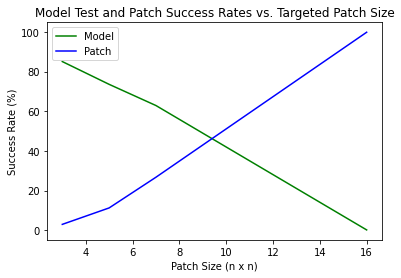

In [6]:
import matplotlib.pyplot as plt
patch_size = [3, 5, 7, 16]
model_sr = [85.10, 73.60, 62.90, 0.10]
patch_sr = [2.90, 11.20, 26.70, 99.90]
plt.plot(patch_size, model_sr, 'g-', label='Model')
plt.plot(patch_size, patch_sr, 'b-', label='Patch')
plt.xlabel('Patch Size (n x n)')
plt.ylabel('Success Rate (%)')
plt.legend()
plt.title('Model Test and Patch Success Rates vs. Targeted Patch Size')
plt.show()

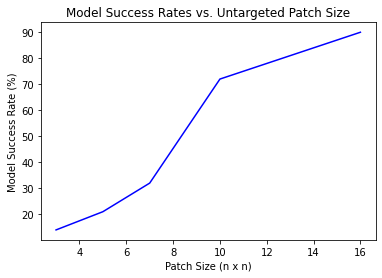

In [1]:
import matplotlib.pyplot as plt
patch_size = [3, 5, 7, 10, 16]
model_sr = [100 - 86.00, 100 - 79.00, 100 - 68.00, 100 - 28.00, 100 - 10.00]
plt.plot(patch_size, model_sr, 'b-')
plt.xlabel('Patch Size (n x n)')
plt.ylabel('Model Success Rate (%)')

plt.title('Model Success Rates vs. Untargeted Patch Size')
plt.show()